## Partitionner les vidéos

**But :** Partitionner les vidéos par séquences de comportement pour avoir une vidéo par comportement étiqueté.

Organisation :
* videos de 30 sec
* fichier format csv regroupant les times codes et labels pour chaque vidéo

| Date | Molecule | Concentration | T | N° vidéo | Label | Start (s) | End (s) | Se tortille (Oui), ne se tortille pas (non) |
|:----------:|:--------:|:------------:|:----------:|:--------:|:------------:|:----------:|:--------:|:------------:|

In [2]:
from os import listdir
from os.path import isfile
from pathlib import Path

import cv2

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import imutils
import math

### Définition des fichiers et répertoires de travail

In [6]:
videos_path = "../data/videos"
save_folder = "../data/0,5_sec_v2"

### Charger le fichier de labelisation

In [5]:
def load_file(file_path):
    columns_names = ['date','molecule','concentration','temps','num','label','start','end','tortille']
    label_file = pd.read_csv(file_path, header = 0, names=columns_names)

    label_file = label_file.replace(to_replace='OUI', value=1)
    label_file = label_file.replace(to_replace='NON', value=0)

    # rajouter un '0' devant le num pour coller au nom des vidéos
    label_file['num'] = '0' + label_file['num'].astype(str)

    # enlever la majuscule du nom de la molecule non présente dans le nom des vidéos
    label_file = label_file.replace(to_replace='L-Glutamate', value='L-glutamate')

    return label_file

### Extraction des différents comportements par vidéos

Le nom de chaque vidéo est la concatéation  de *date_molecule_concentration_temps_num*

In [4]:
import os

# Remplace les espaces dans le nom des vidéos par '_'
def rename_videos(videos_path):
    videos = [v for v in listdir(videos_path) if v.count('.csv') == 0]
    
    for video  in videos:
        if video.count(' ') > 0:
            os.rename(f"{videos_path}/{video}",f"{videos_path}/{video.replace(' ','_')}")
            
rename_videos(videos_path)

Etape préli : Créer un dossier *labels* puis un sous dossier par label référencés dans le csv

Pour chaque ligne dans le df
* récupérer le nom de la vidéo en concatenant
* récupérer le label assigné
* récupérer le time code de début et fin
* créer un dossier par vidéo
* split la vidéo selon tc et save dans labels/label_assigne et dans le dossier de la vidéo



In [52]:
def create_labels_folders(label_file):
    labels = list(set(label_file['label']))
    
    Path(f"{save_folder}/labels").mkdir(parents=True, exist_ok=True)
    for label in labels:
        Path(f"{save_folder}/labels/{label}").mkdir(parents=True, exist_ok=True)

In [7]:
def crop_image(prev_frame, current_frame, size=(350,350)):
    save_img = current_frame[10:,:,:]
    prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)[10:,]
    current_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)[10:,]
    
    frameDelta = cv2.absdiff(prev_frame, current_frame)
    thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
                
    if len(cnts) != 0:
        largestCont = cnts[0]
    
        (x, y, w, h) = cv2.boundingRect(largestCont)
        center = (math.ceil((x+(x+w))/2), math.ceil((y+(y+h))/2))
        x1 = center[0] - size[0]//2
        x2 = center[0] + size[0]//2
        y1 = center[1] - size[1]//2
        y2 = center[1] + size[1]//2

        if x1 < 0:
            x2 += abs(x1)
            x1 = 0
                    
        if x2 > thresh.shape[1]:
            x1 -= abs(x2)
            x2 = thresh.shape[1]

        if y1 < 0:
            y2 += abs(y1)
            y1 = 0 
                    
        if y2 > thresh.shape[0]:
            y1 -= abs(y2)
            y2 = thresh.shape[0] 
                
        return (True, save_img[y1:y2, x1:x2, :])

    return (False, None)

In [8]:
def video_to_frames(video_name, video_path, timecode, tortille, outputs):
    print(video_name)
    # on commence par créer les différents dossiers
    for out in outputs:
        Path(out).mkdir(parents=True, exist_ok=True)
    
    # on sort le path de tortille de la liste car il dépend d'une condition
    tortille_folder = outputs.pop(-1)
    Path(f"{tortille_folder}/oui").mkdir(parents=True, exist_ok=True)
    Path(f"{tortille_folder}/non").mkdir(parents=True, exist_ok=True)
    
    num_oui = len(listdir(f"{tortille_folder}/oui"))
    num_non = len(listdir(f"{tortille_folder}/non"))

    start, end = timecode
    f = 1
    vidcap = cv2.VideoCapture(video_path)
    if vidcap.isOpened():
        #print('video opened')
        success, prev_frame = vidcap.read()
        
        while success:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(f*1000))
            success,current_frame = vidcap.read()
            if success :
                save_img = current_frame[10:,:,]
                
                diff ,img = crop_image(prev_frame, current_frame)

                if diff:
                    if f >= start and f <= end:
                        for out in outputs:
                            cv2.imwrite( f"{out}/{video_name}_frame{f}.jpg", img)
                        
                        if tortille:
                            path = f"{tortille_folder}/oui"
                            Path(f"{path}/{num_oui}").mkdir(parents=True, exist_ok=True)
                            cv2.imwrite( f"{path}/{num_oui}/{f}.jpg", img)
                        else:
                            path = f"{tortille_folder}/non"
                            Path(f"{path}/{num_non}").mkdir(parents=True, exist_ok=True)
                            cv2.imwrite( f"{path}/{num_non}/{f}.jpg", img)
                
                    else:
                        # dans tous les cas on save l'image dans all
                        cv2.imwrite( f"{outputs[-1]}/{video_name}_frame{f}.jpg", img)
                
                
                prev_frame = current_frame
                f+=1

In [9]:
def extract_data(folder_path, label_file):

    #create_labels_folders(folder_path, label_file)
    
    for index, row in label_file.iterrows():
        video_name = f"{row['date'].replace('2022','22')}_{row['molecule']}_{row['concentration']}_{row['temps']}_{row['num']}"
        video_path = f"{folder_path}/{video_name}.avi"
        label = row['label']
        tortille = row['tortille']
        timecode = (int(row['start'][3:]),int(row['end'][3:]))

        # les différents repertoires où save les images
        outputs = [f"{save_folder}/video_frames/{video_name}/{label}", # dossier propre à chaque vidéos
                   f"{save_folder}/labels/{label}",                    # les différents labels
                   f"{save_folder}/all",                               # toutes les images extraites
                   f"{save_folder}/tortille"]                          # tortille 

        video_to_frames(video_name, video_path, timecode, tortille, outputs)

In [10]:
list_to_extract = {"L-glutamate" : "Labelisation_L-glutamate_12-04-22_LR.csv",
                    "Apomorphine" : "Labellisation_Apomorphine_28-04-22_LR.csv"}

for folder in list_to_extract:
    label_file_path = f"{videos_path}/{folder}/{list_to_extract[folder]}"
    
    label_file = load_file(label_file_path)
    extract_data(f"{videos_path}/{folder}", label_file)

12-04-22_L-glutamate_0_T0_01
12-04-22_L-glutamate_0_T0_02
12-04-22_L-glutamate_0_T0_03
12-04-22_L-glutamate_0_T0_03
12-04-22_L-glutamate_0_T0_03
12-04-22_L-glutamate_0_T0_04
12-04-22_L-glutamate_0_T0_05
12-04-22_L-glutamate_0_T0_06
12-04-22_L-glutamate_0_T0_07
12-04-22_L-glutamate_0_T0_08
12-04-22_L-glutamate_0_T0_01
12-04-22_L-glutamate_0,1_T0_02
12-04-22_L-glutamate_0,1_T0_03
12-04-22_L-glutamate_0,1_T0_03
12-04-22_L-glutamate_0,1_T0_03
12-04-22_L-glutamate_0,1_T0_03
12-04-22_L-glutamate_0,1_T0_04
12-04-22_L-glutamate_0,1_T0_05
12-04-22_L-glutamate_1_T0_01
12-04-22_L-glutamate_1_T0_01
12-04-22_L-glutamate_1_T0_03
12-04-22_L-glutamate_1_T0_04
12-04-22_L-glutamate_1_T0_06
12-04-22_L-glutamate_1_T0_08
12-04-22_L-glutamate_5_T0_01
12-04-22_L-glutamate_5_T0_01
12-04-22_L-glutamate_5_T0_03
12-04-22_L-glutamate_5_T0_05
12-04-22_L-glutamate_5_T0_06
12-04-22_L-glutamate_5_T0_07
12-04-22_L-glutamate_5_T0_08
12-04-22_L-glutamate_10_T0_03
12-04-22_L-glutamate_10_T0_06
12-04-22_L-glutamate_10_T0_

### Visualisation des images extraites

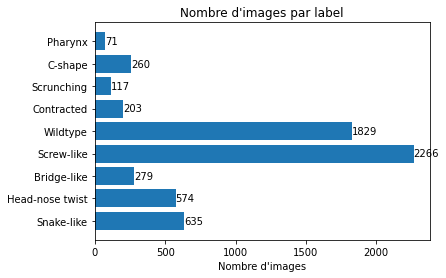

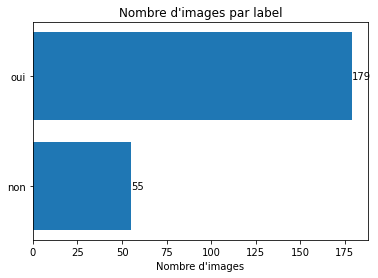

In [11]:
def images_count(folder):
    labels = listdir(folder)
    count = []

    for label in labels:
        imgs = listdir(f"{folder}/{label}")
        count.append(len(imgs))
    
    fig, ax = plt.subplots()
    y_pos = np.arange(len(labels))

    ax.barh(y_pos, count)
    for bars in ax.containers:
        ax.bar_label(bars)
    ax.set_yticks(y_pos, labels=labels)
    ax.invert_yaxis()
    ax.set_xlabel('Nombre d\'images')
    ax.set_title('Nombre d\'images par label')

    plt.show()



images_count(f"{save_folder}/labels")
images_count(f"{save_folder}/tortille")